# Proyecto 1: Revisión de sentimientos en comentarios de libros
## Integrantes:
* Natalia Sanabria Forero - 201532265
* Jorge Andrés Esguerra Alarcón - 201719920
* Christian Forigua - 201713023

In [1]:
# Librería para manejar las contracciones que se presentan en el inglés.
!pip install contractions
!pip install numpy -U
!pip install joblib
# librería para manejar las flexiones gramaticales en el idioma inglés.
!pip install inflect
!pip install pandas-profiling==2.7.1
!pip install nltk
!pip install sklearn

Requirement already up-to-date: numpy in /Users/nataliasanabria/opt/anaconda3/lib/python3.8/site-packages (1.21.2)


## 1. Librerías para el procesamiento de texto

In [2]:
# Procesamiento de Lenguaje Natural
import nltk
nltk.download('punkt') # Separar texto en frases
nltk.download('stopwords') # Palabras vacías
nltk.download('wordnet') # Entender el significado de las palabras

# Otras librerías
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import sys
from pandas_profiling import ProfileReport

import re, string, unicodedata
import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix, plot_precision_recall_curve, accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin

import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nataliasanabria/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nataliasanabria/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nataliasanabria/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 2. Perfilamiento y entendimiento de los datos
### Lectura de los datos

In [3]:
data = pd.read_csv('./kindle_reviews.csv')
data.head()

,Unnamed: 0,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0,B000F83SZQ,"[0, 0]",5,I enjoy vintage books and movies so I enjoyed ...,"05 5, 2014",A1F6404F1VG29J,Avidreader,Nice vintage story,1399248000
1,1,B000F83SZQ,"[2, 2]",4,This book is a reissue of an old one; the auth...,"01 6, 2014",AN0N05A9LIJEQ,critters,Different...,1388966400
2,2,B000F83SZQ,"[2, 2]",4,This was a fairly interesting read. It had ol...,"04 4, 2014",A795DMNCJILA6,dot,Oldie,1396569600
3,3,B000F83SZQ,"[1, 1]",5,I'd never read any of the Amy Brewster mysteri...,"02 19, 2014",A1FV0SX13TWVXQ,"Elaine H. Turley ""Montana Songbird""",I really liked it.,1392768000
4,4,B000F83SZQ,"[0, 1]",4,"If you like period pieces - clothing, lingo, y...","03 19, 2014",A3SPTOKDG7WBLN,Father Dowling Fan,Period Mystery,1395187200


In [4]:
# Dimensiones de los datos
rows, cols = data.shape
print(f"filas: {rows}, columnas: {cols}")

filas: 982619, columnas: 10


### Entendimiento de los datos

In [6]:
data.describe()

,Unnamed: 0,overall,unixReviewTime
count,982619.000000,982619.000000,9.826190e+05
mean,491309.000000,4.347801,1.378183e+09
std,283657.816416,0.955056,2.298476e+07
min,0.000000,1.000000,9.522144e+08
25%,245654.500000,4.000000,1.365206e+09
50%,491309.000000,5.000000,1.383523e+09
75%,736963.500000,5.000000,1.396051e+09
max,982618.000000,5.000000,1.406074e+09


In [7]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 982619 entries, 0 to 982618
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Unnamed: 0      982619 non-null  int64 
 1   asin            982619 non-null  object
 2   helpful         982619 non-null  object
 3   overall         982619 non-null  int64 
 4   reviewText      982597 non-null  object
 5   reviewTime      982619 non-null  object
 6   reviewerID      982619 non-null  object
 7   reviewerName    978803 non-null  object
 8   summary         982618 non-null  object
 9   unixReviewTime  982619 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 75.0+ MB


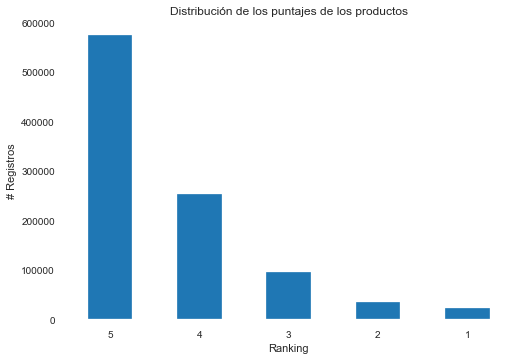

In [8]:
data['overall'].value_counts().plot(kind = 'bar')
plt.title('Distribución de los puntajes de los productos')
plt.xlabel('Ranking')
plt.xticks(rotation = 0)
plt.ylabel('# Registros')
plt.show()

In [9]:
df_data = (data.isna().sum()).to_frame()
df_data.sort_values(0, ascending = False)

,0
reviewerName,3816
reviewText,22
summary,1
Unnamed: 0,0
asin,0
helpful,0
overall,0
reviewTime,0
reviewerID,0
unixReviewTime,0


In [7]:
reviews = data[['reviewText', 'overall','summary']]
df_data = (reviews.isna().sum()).to_frame()
df_data.sort_values(0, ascending = False)

,0
reviewText,22
summary,1
overall,0


In [8]:
reviews.dropna(inplace = True)
reviews

,reviewText,overall,summary
0,I enjoy vintage books and movies so I enjoyed ...,5,Nice vintage story
1,This book is a reissue of an old one; the auth...,4,Different...
2,This was a fairly interesting read. It had ol...,4,Oldie
3,I'd never read any of the Amy Brewster mysteri...,5,I really liked it.
4,"If you like period pieces - clothing, lingo, y...",4,Period Mystery
...,...,...,...
982614,Yasss hunny! This is a great read. That Dre is...,5,A Hot Read Indeed!!
982615,I ENJOYED THIS BOOK FROM BEGINNING TO END NOW ...,5,VERY GOOD BOOK
982616,Great book! Cherika was a fool. She let that m...,5,Great Read
982617,When I say this was an excellent book please b...,5,Wow!!


## 3. Preparación de los datos
### 3.1 Limpieza de los datos

In [9]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if not word.isdigit():
            new_words.append(word)
        #if word.isdigit():
            #new_word = p.number_to_words(word)
            #new_words.append(new_word)
        #else:
            #new_words.append(word)
    return new_words
def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_words.append(word.lower())
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    stop_words = set(stopwords.words('english'))
    for word in words:
        if word not in stop_words:
            new_words.append(word)
    return new_words

def preprocessing(words):
    words = to_lowercase(words)
    words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

### 3.2 Tokenización

In [10]:
# Se preparan los reviews para la tokenización
reviews['reviewText'] = reviews['reviewText'].apply(contractions.fix)
reviews['summary'] = reviews['summary'].apply(contractions.fix)
reviews

,reviewText,overall,summary
0,I enjoy vintage books and movies so I enjoyed ...,5,Nice vintage story
1,This book is a reissue of an old one; the auth...,4,Different...
2,This was a fairly interesting read. It had ol...,4,Oldie
3,I would never read any of the Amy Brewster mys...,5,I really liked it.
4,"If you like period pieces - clothing, lingo, y...",4,Period Mystery
...,...,...,...
982614,Yasss hunny! This is a great read. That Dre is...,5,A Hot Read Indeed!!
982615,I ENJOYED THIS BOOK FROM BEGINNING TO END NOW ...,5,VERY GOOD BOOK
982616,Great book! Cherika was a fool. She let that m...,5,Great Read
982617,When I say this was an excellent book please b...,5,Wow!!


Se decidió guardar la columna "summary" ya que podría aportar información a la representación de los reviews. Para verificar lo anterior, se va a crear una representación que solo tiene en cuenta la columna "reviewText" y otra que va tener las columnas "reviewText" y "Summary" concatenadas.

In [11]:
#reviews_summary = reviews.copy()
#reviews_summary['reviewText'] = reviews_summary['reviewText'] + ' ' + reviews_summary['summary']
#reviews_summary = reviews_summary[['reviewText', 'overall']]
reviews = reviews[['reviewText', 'overall']]
reviews

,reviewText,overall
0,I enjoy vintage books and movies so I enjoyed ...,5
1,This book is a reissue of an old one; the auth...,4
2,This was a fairly interesting read. It had ol...,4
3,I would never read any of the Amy Brewster mys...,5
4,"If you like period pieces - clothing, lingo, y...",4
...,...,...
982614,Yasss hunny! This is a great read. That Dre is...,5
982615,I ENJOYED THIS BOOK FROM BEGINNING TO END NOW ...,5
982616,Great book! Cherika was a fool. She let that m...,5
982617,When I say this was an excellent book please b...,5


In [12]:
#reviews_summary['words'] = reviews_summary['reviewText'].apply(word_tokenize).apply(preprocessing)
reviews['words'] = reviews['reviewText'].apply(word_tokenize).apply(preprocessing) #Aplica la eliminación del ruido
reviews.head()

,reviewText,overall,words
0,I enjoy vintage books and movies so I enjoyed ...,5,"[enjoy, vintage, books, movies, enjoyed, readi..."
1,This book is a reissue of an old one; the auth...,4,"[book, reissue, old, one, author, born, 1910, ..."
2,This was a fairly interesting read. It had ol...,4,"[fairly, interesting, read, old, style, termin..."
3,I would never read any of the Amy Brewster mys...,5,"[would, never, read, amy, brewster, mysteries,..."
4,"If you like period pieces - clothing, lingo, y...",4,"[like, period, pieces, clothing, lingo, enjoy,..."


In [13]:
reviews.head()

,reviewText,overall,words
0,I enjoy vintage books and movies so I enjoyed ...,5,"[enjoy, vintage, books, movies, enjoyed, readi..."
1,This book is a reissue of an old one; the auth...,4,"[book, reissue, old, one, author, born, 1910, ..."
2,This was a fairly interesting read. It had ol...,4,"[fairly, interesting, read, old, style, termin..."
3,I would never read any of the Amy Brewster mys...,5,"[would, never, read, amy, brewster, mysteries,..."
4,"If you like period pieces - clothing, lingo, y...",4,"[like, period, pieces, clothing, lingo, enjoy,..."


### 3.3 Normalización

In [19]:
def stem_words(words):
    """Stem words in list of tokenized words"""
    lancaster=LancasterStemmer()
    new_words =[]
    for word in words:
        new_words.append(lancaster.stem(word))
    return new_words    

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    new_words =[]
    for word in words:
        new_words.append(lemmatizer.lemmatize(word))
    return new_words  

def delete_duplicates(words):
    rta = list(set(words))
    return rta

def stem_and_lemmatize(words):
    stems = stem_words(words)
    lemmas = lemmatize_verbs(words)
    total = stems + lemmas
    return delete_duplicates(total)

In [20]:
reviews['words'] = reviews['words'].apply(stem_and_lemmatize) #Aplica lematización y Eliminación de Prefijos y Sufijos.
#reviews_summary['words'] = reviews_summary['words'].apply(stem_and_lemmatize) #Aplica lematización y Eliminación de Prefijos y Sufijos.
reviews.head()

,reviewText,overall,words
0,I enjoy vintage books and movies so I enjoyed ...,5,"[someon, unus, scen, wash, un, someone, selfde..."
1,This book is a reissue of an old one; the auth...,4,"[say, langu, looks, worth, 1910, looksee, one,..."
2,This was a fairly interesting read. It had ol...,4,"[styl, coarse, check, fre, coar, langu, relax,..."
3,I would never read any of the Amy Brewster mys...,5,"[really, brewster, never, real, hook, read, ho..."
4,"If you like period pieces - clothing, lingo, y...",4,"[piec, lik, like, guess, author, au, enjoy, wa..."


In [16]:
reviews.sample(3)

,reviewText,overall,words
673497,Taylor has done it again with another series w...,5,"[say, don, badass, taylor, act, sexy, said, an..."
687359,Oh my god! I loved this book so much! Jonathon...,5,"[enjoy, buy, much, sexy, loved, shade, lov, go..."
468841,This book brought back memories of my first ex...,4,"[really, unr, wil, say, develop, grad, hap, un..."


In [17]:
#reviews_summary.sample(3)

### Selección y preparación de los datos

In [21]:
# Se toma como un sentimiento positivo 4 y 5. Para los valores de 3,2 y 1 se entiende que el sentimiento es negativo. Para el sentimiento
# positivo se toma el label de 1 y para el sentimiento negativo se toma la entrada de 0.
def sentimiento_binario(score):
    if(score <=3):
        return 0
    else:
        return 1

reviews["binary_feeling_score"] = reviews.overall.apply(sentimiento_binario)
#reviews_summary["binary_feeling_score"] = reviews_summary.overall.apply(sentimiento_binario)
reviews.head(5)

,reviewText,overall,words,binary_feeling_score
0,I enjoy vintage books and movies so I enjoyed ...,5,"[someon, unus, scen, wash, un, someone, selfde...",1
1,This book is a reissue of an old one; the auth...,4,"[say, langu, looks, worth, 1910, looksee, one,...",1
2,This was a fairly interesting read. It had ol...,4,"[styl, coarse, check, fre, coar, langu, relax,...",1
3,I would never read any of the Amy Brewster mys...,5,"[really, brewster, never, real, hook, read, ho...",1
4,"If you like period pieces - clothing, lingo, y...",4,"[piec, lik, like, guess, author, au, enjoy, wa...",1


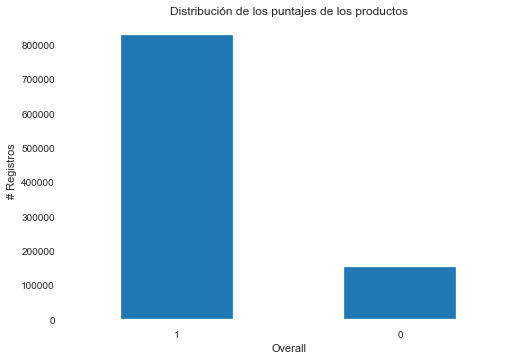

In [22]:
reviews['binary_feeling_score'].value_counts().plot(kind = 'bar')
plt.title('Distribución de los puntajes de los productos')
plt.xlabel('Overall')
plt.xticks(rotation = 0)
plt.ylabel('# Registros')
plt.show()

Finalmente, eliminamos la columna overall dado que fue mappeada a binary_feeling_score y no debería usarse como variable predictora. Queremos clasificar solo a base de palabras.

In [23]:
reviews = reviews.drop(["overall", "reviewText"], axis=1)

In [24]:
reviews.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 982596 entries, 0 to 982618
Data columns (total 2 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   words                 982596 non-null  object
 1   binary_feeling_score  982596 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 22.5+ MB


#### Como cada texto ahora es un arreglo de palabras (columna words), es necesario volver a unirlos para poder aplicar el countVectorizer sobre el corpus de cada texto después del procesamiento (limpieza). 

In [25]:
final_reviews = reviews["words"].copy().apply(lambda arr: " ".join(arr))
reviews["words"] = final_reviews.copy()
reviews["final_text"] = reviews["words"].copy()
reviews.drop(axis=1, columns=["words"])

,binary_feeling_score,final_text
0,1,someon unus scen wash un someone selfdefens hi...
1,1,say langu looks worth 1910 looksee one nev als...
2,1,styl coarse check fre coar langu relax crud te...
3,1,really brewster never real hook read hooked br...
4,1,piec lik like guess author au enjoy way cloth ...
...,...,...
982614,1,chenell mess paty cherik say axy else gone go ...
982615,1,cherik pt2 chant beginning hurting wait damn g...
982616,1,cheating che cherik alex hope nev also wait ge...
982617,1,plea believe say went thing please wait unbeli...


Se observó previamente que existe un gran desbalance entre la clase mayoritaria de sentimientos positivos y la clase minoritaria de sentimientos negativos. Dicho desbalance podría tener un impacto considerable en el modelo, por lo que se decidió aplicar estrategías para el tratamiento de los datos desbalanceados. Se decidió utilizar la técnica de Under-sampling para disminuir la brecha entre las clases.

In [26]:
!pip install imbalanced-learn

In [27]:
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
X, Y= undersample.fit_resample(reviews, reviews.binary_feeling_score)

In [28]:
x_train,x_test,y_train,y_test = train_test_split(X.final_text,Y, random_state = 0, test_size=0.2)

In [29]:
count_vectorizer = CountVectorizer(min_df=0,max_df=1,ngram_range=(1,1))
X_count_train = count_vectorizer.fit_transform(x_train)
tfid_vectorizer = TfidfVectorizer()
X_tfid_train = tfid_vectorizer.fit_transform(x_train)

X_count_test = count_vectorizer.transform(x_test)
X_tfid_test =  tfid_vectorizer.transform(x_test)
#x_train,x_test,y_train,y_test = train_test_split(reviews.reviewText,reviews.binary_feeling_score , random_state = 0)

In [30]:
print('Bag of words count train',X_count_train.shape)
print('Bag of words count test',X_count_test.shape)
print('Bag of words tfid train',X_tfid_train.shape)
print('Bag of words tfid test',X_tfid_test.shape)

Bag of words count train (368018, 355920)
Bag of words count test (92005, 355920)
Bag of words tfid train (368018, 508161)
Bag of words tfid test (92005, 508161)


## 4. Construcción de los modelos

In [32]:
from sklearn.linear_model import LogisticRegression

### 4.2 LogisticRegression - Elaborado por Natalia Sanabria

La Regresión Logística es un método de regresión desarrollado en 1958 por David Cox, que permite estimar la probabilidad de una variable cualitativa binaria en función de una variable cuantitativa. La función logística. también llamada función sigmoide se describe con la siguiente fórmula:

$f(x) = \frac{1}{1+e^{-x}}$

Es una curva en donde se retorma 1 si el dominio tiende a infinito positivo o cero si tiende a infinito negativo.

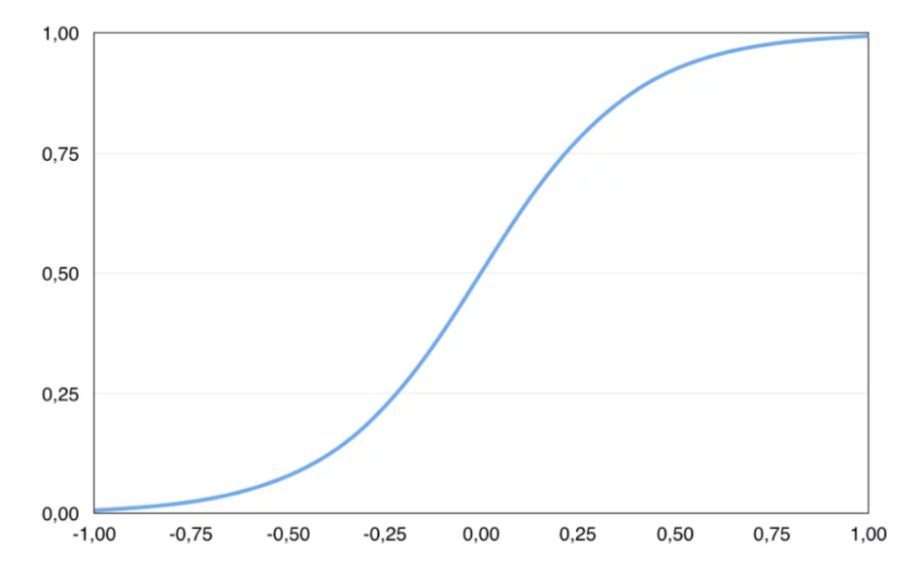

In [33]:
lr = LogisticRegression()
lr.fit(X_count_train,y_train)

LogisticRegression()

In [36]:
predictions = lr.predict(X_count_test)

#### Análisis

In [45]:
# find accuracy, precision, recall:
from sklearn.metrics import confusion_matrix,classification_report
new = np.asarray(y_test)
confusion_matrix(y_test, predictions)

array([[  406, 30365],
       [  411, 60823]])

Text(0.5, 26.0, 'Clase predicha')

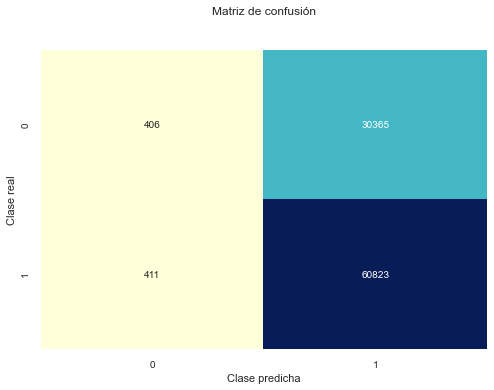

In [44]:
from sklearn import metrics
import seaborn as sns 

cnf_matrix = metrics.confusion_matrix(y_test, predictions)
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g', cbar=False)
plt.title('Matriz de confusión', y=1.1)
plt.ylabel('Clase real')
plt.xlabel('Clase predicha')

In [38]:
print(classification_report(predictions, y_test))

              precision    recall  f1-score   support

           0       0.01      0.50      0.03       817
           1       0.99      0.67      0.80     91188

    accuracy                           0.67     92005
   macro avg       0.50      0.58      0.41     92005
weighted avg       0.98      0.67      0.79     92005



Como se puede ver en el diagrama de la matriz de confusión, es fácil apreciar que el modelo tiende a categorizar todos los reviews como comentarios positivos, mientras que obvia los negativos. Debido a que el modelo no se puede parametrizar, resulta poco evidente cómo se podrían mejorar las predicciones. 

No obstante, se observa que tiene una exactitud del 67%, que no es un valor bajo, y fue un modelo capaz de correr en escasos minutos (alrededor de 3) por lo que no debería descartarse su utilidad para lidiar con conjuntos de datos tan extensos y lograr ajustes relativamente buenos.